In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

In [2]:
%matplotlib inline
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [3]:
df = pd.read_excel('../data/Prices.xlsx', sheet_name='Daily', skiprows=8, usecols='D:E', index_col='Name')
df.index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

In [19]:
df.index[-1] - df.index[0], len(df) # some daily values are missing. so imputing them for index in ARIMA

(Timedelta('15813 days 00:00:00'), 11296)

In [139]:
df_filled = df.asfreq('5Y').interpolate(method='time')

In [151]:
model_arima_d = ARIMA(df_filled['US dollar'], order=(1,1,1), freq='5Y', dates=df_filled.index, seasonal_order=(1,1,1,3))
model_arima_d_fit = model.fit()

ValueError: The given frequency argument is incompatible with the given index.

In [146]:
pred = model_arima_d_fit.predict(start=-40, end=16000)

(1400.0, 2200.0)

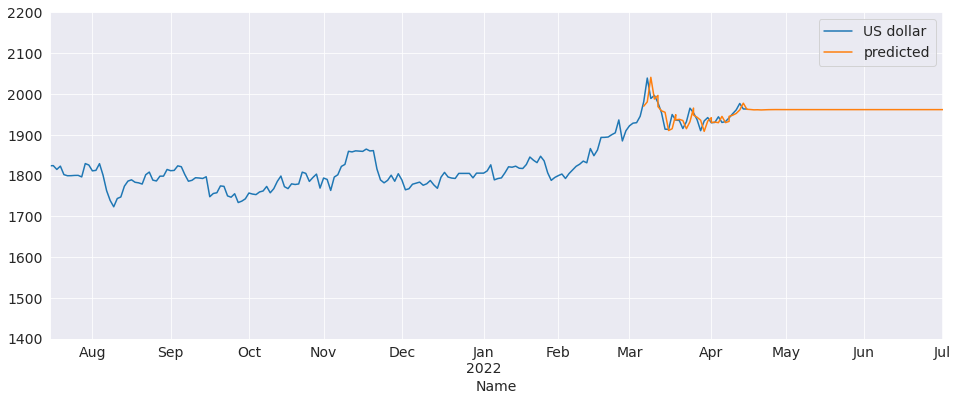

In [147]:
df.plot(label='actual')
pred.plot(label='predicted')
plt.legend()
plt.xlim(pd.Timestamp('2021-07-15'), pd.Timestamp('2022-07-01'))
plt.ylim(1400, 2200)

In [196]:
df_filled_less = df.asfreq('D').interpolate(method='time')
df_filled_less = df_filled_less[len(df_filled_less)//3:]

In [232]:
df_filled_less

,US dollar
Name,
1993-06-04,377.60
1993-06-05,376.00
1993-06-06,374.40
1993-06-07,372.80
1993-06-08,375.25
...,...
2022-04-11,1951.55
2022-04-12,1960.85
2022-04-13,1976.75


In [212]:
model_sarimax = SARIMAX(df_filled_less, trend=[1,1,1,1], order=(1,0,3))
model_sarimax_fit = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55818D+00    |proj g|=  1.20758D+16


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   1.208D+16   3.558D+00
  F =   3.5581794576684489     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


(1400.0, 2200.0)

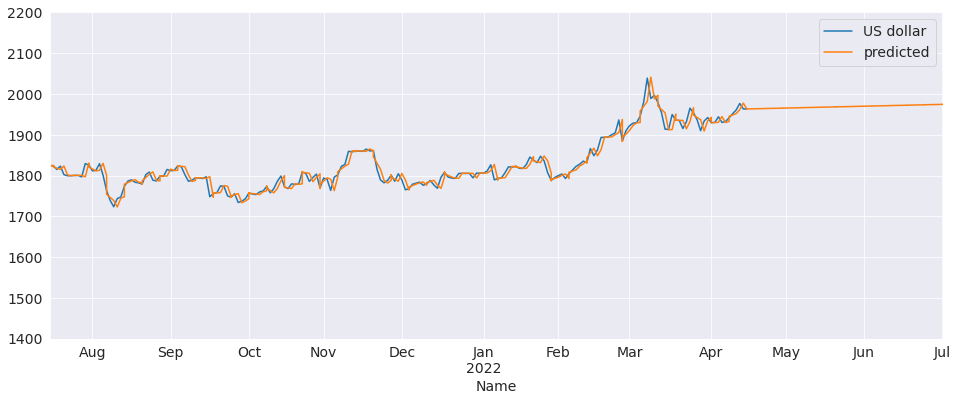

In [213]:
pred = model_sarimax_fit.predict(end=11000)
df.plot(label='actual')
pred.plot(label='predicted')
plt.legend()
plt.xlim(pd.Timestamp('2021-07-15'), pd.Timestamp('2022-07-01'))
plt.ylim(1400, 2200)

In [231]:
from pmdarima import auto_arima

In [236]:
model = auto_arima(df_filled_less['US dollar'], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_filled_less['US dollar'])

forecast = model.predict(n_periods=200)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=75032.783, Time=4.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75040.897, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75029.147, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=75029.509, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75042.198, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75029.301, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=75028.788, Time=3.92 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=75030.719, Time=4.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=75030.780, Time=1.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=75029.535, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=75029.735, Time=0.88 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 19.591 seconds


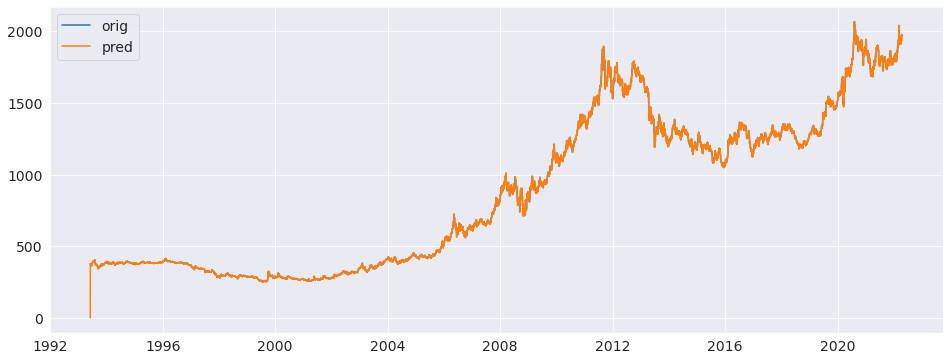

In [271]:
plt.plot(df_filled_less['US dollar'], label='orig')
plt.plot(pd.Series(model.predict_in_sample(), index=df_filled_less.index), label='pred')
plt.legend()

<AxesSubplot:>

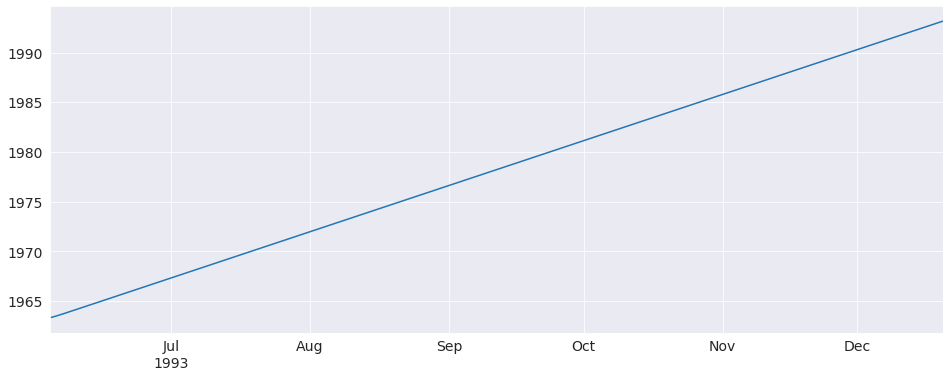

In [255]:
pd.Series(forecast, index=pd.date_range(start=df_filled_less.index[0], end=df_filled_less.index[199])).plot()